In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "16" # OpenMP will otherwise use all cores
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

# Load pre-processed Perturbseq experiment from hdf5

Populations are constructed in notebook *GI generate populations*

In [2]:
pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/final_single_cell_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 32.358438015s.
Done.


In [3]:
pop.info()

Matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: int32(24665)
memory usage: 8.6 GB

Normalized matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: float64(24665)
memory usage: 17.2 GB


In [4]:
control_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/control_pop.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 2.53118991852s.
Done.


In [5]:
mean_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/mean_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.198467969894s.
Done.


# Load emap information

In [6]:
# these have different names in the emap and in GChr38
name_replacer = {'C3orf72': 'FOXL2NB',
                 'C19orf26': 'CBARP',
                 'KIAA1804': 'RP5-862P8.2',
                 'RHOXF2': 'RHOXF2B',
                }

inverse_name_replacer = {v: k for k, v in name_replacer.iteritems()}

In [7]:
emap = pd.read_csv('./final_emaps/processed_emap.csv', index_col=[0])
phen_matrix = pd.read_csv('./final_emaps/processed_fitnesses.csv', index_col=[0])
single_phen = pd.read_csv('./final_emaps/single_fitnesses_no_filter.csv', index_col=[0])

In [8]:
# this is average fitness across two guides in primary emap, not single guide used for perturbseq
single_fitnesses = single_phen['average_fitness']

# fitness mapper, maps names to raw fitness values
fitness_mapper = dict()
for perturbation in pop.cells['guide_target'].unique():
    first, second = perturbation.split('_')
    try:
        if 'NegCtrl' in second:
            fitness_mapper[perturbation] = single_fitnesses.loc[first]
        elif 'NegCtrl' in first:
            fitness_mapper[perturbation] = single_fitnesses.loc[second]
        else:
            fitness_mapper[perturbation] = phen_matrix.loc[first, second]
    except KeyError:
        fitness_mapper[perturbation] = np.nan

In [9]:
single_genes = np.intersect1d(reduce(np.union1d, mean_pop.cells.query('num_targets == 1')['guide_target'].map(lambda x: x.split('_'))),
               emap.columns.map(lambda x: name_replacer.get(x, x)))
# we know these don't work...
single_genes = np.setdiff1d(single_genes, ['BAK1', 'BCL2L11'])

# maps gene name to single (SLC38A2 is the lone exception where we don't have it in position 1)
single_gene_perturbations = dict()

for gene in single_genes:
    if gene + '_NegCtrl0' in mean_pop.cells.index:
        single_gene_perturbations[gene] = gene + '_NegCtrl0'
    elif 'NegCtrl0_' + gene in mean_pop.cells.index:
        single_gene_perturbations[gene] = 'NegCtrl0_' + gene
        
double_perturbations = mean_pop.cells.query('num_targets == 2').index
perturbations = single_gene_perturbations.values()

for p in double_perturbations:
    gene1, gene2 = p.split('_')
    if gene1 in single_genes and gene2 in single_gene_perturbations.keys():
        perturbations.append(p)
        
fitnesses = mean_pop.cells.loc[perturbations, 'fitness']

mapper = {v: k for k, v in single_gene_perturbations.iteritems()}

# Restrict to things with transcriptional phenotypes

In [10]:
ks, ps, adj_ps = ks_de(pop,
                       key='guide_target',
                       control_cells='perturbed == "control"',
                       genes='mean > 0.5',
                       normalized=True,
                       alpha=0.001,
                       n_jobs=24)

7353 control cells
groupby: index in @key_barcodes (key = guide_target)


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    4.2s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:    7.7s
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   12.0s
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:   16.3s
[Parallel(n_jobs=24)]: Done  50 tasks      | elapsed:   21.0s
[Parallel(n_jobs=24)]: Done  65 tasks      | elapsed:   26.2s
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed:   30.7s
[Parallel(n_jobs=24)]: Done  97 tasks      | elapsed:   36.7s
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:   42.8s
[Parallel(n_jobs=24)]: Done 133 tasks      | elapsed:   50.7s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   57.0s
[Parallel(n_jobs=24)]: Done 173 tasks      | elapsed:  1.1min
[Parallel(n_jobs=24)]: Done 194 tasks      | elapsed:  1.2min
[Parallel(n_jobs=24)]: Done 217 tasks      | elapsed:  1.3min
[Parallel(n_jobs=24)]: Done 240 tasks      | elapsed:  1.5min
[Parallel(n_jobs=24)]: Done 269 out of 287 | elapsed:  1.6min remainin

In [11]:
de_genes = (adj_ps < 0.001).sum().loc[single_gene_perturbations.values()]
good_genes = np.intersect1d(de_genes[de_genes > 10].index.map(lambda x: mapper[x]), emap.columns)
good_perturbations = [single_gene_perturbations[x] for x in good_genes]

# Make linkages used for clustering figures

In [12]:
single_mean_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/single_mean_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.11333489418s.
Done.


In [13]:
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from matplotlib import colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

In [14]:
#### colormap
#'#20B6E2' -> '#F4EA18'
# 32,182,226 -> 244,234,24
# .125, .713, .886 -> .957, .918, .094
cdict = {'red':((0.0,0.125,0.125),
                (0.5,0.0,0.0),
                (1.0,0.957,0.957)),
        'green':((0.0,0.713,0.713),
                (0.5,0.0,0.0),
                (1.0,0.918,0.918)),
        'blue': ((0.0,0.886,0.886),
                (0.5,0.0,0.0),
                (1.0,0.094,0.094))}
blue_yellow = matplotlib.colors.LinearSegmentedColormap('BlueYellow',cdict)
blue_yellow.set_bad((.9, .9, .9, 1.0))
plt.register_cmap(cmap=blue_yellow)

These are the GI map and corresponding fitness measurements for the perturbations selected in the previous section

In [15]:
good_emap = emap.loc[good_genes, good_genes]
good_phen = phen_matrix.loc[good_genes, good_genes]

Z_emap = linkage(good_emap, method='ward')
Z_phen = linkage(good_phen, method='ward')

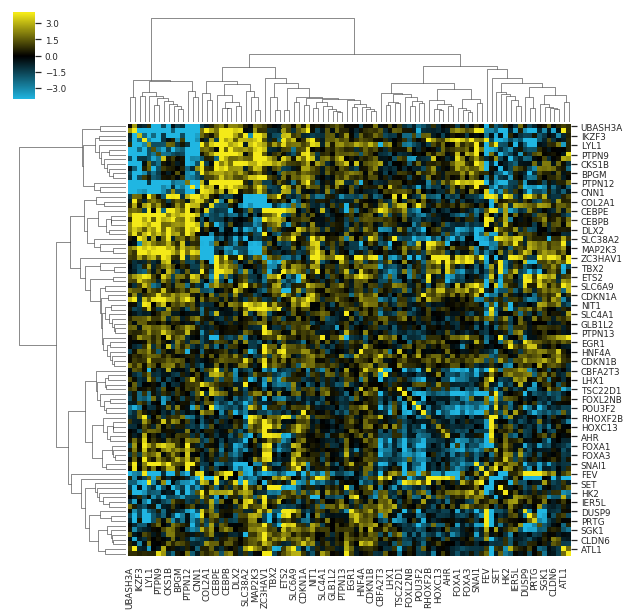

In [16]:
sns.set(font_scale=0.8)
cg = sns.clustermap(good_emap,
                    row_linkage=Z_emap,
                    col_linkage=Z_emap,
                    cmap='BlueYellow',
                    vmin=-4, vmax=4, figsize=[10,10])

# Routines for performing GI prediction

This routine is for subsampling/masking a (symmetric) DataFrame given a list of entries that are observed

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import scipy
from maxide import *

def get_masked_data(df, ind, mean_normalize=False):
    masked_data = df.copy().values
    mask = pd.DataFrame(0, index=df.index, columns=df.columns)
    
    for gene1, gene2 in ind:
        mask.loc[gene1, gene2] = 1 

    # assume DataFrame is symmetric
    mask = mask + mask.T
    mask = (mask != 0).values
    masked_data[~mask] = 0
    masked_data_df = pd.DataFrame(masked_data, index=df.index, columns=df.columns)
    
    # whether to center the observed entries such that the overall mean is 0
    if mean_normalize:
        masked_data_df = masked_data_df.stack()
        offset = masked_data_df[masked_data_df != 0]
        offset = offset.mean()
        masked_data_df[masked_data_df != 0] = masked_data_df[masked_data_df != 0] - offset
        print offset
        masked_data_df = masked_data_df.unstack()
    
    return masked_data_df, mask

## GI prediction

This is an updated version of the `delta_predict` routine from the *GI_prediction* notebook that simultaneously makes predictions using a number of other methods for comparison. Please consult that notebook first to get comfortable with the approach.

In [18]:
from fancyimpute import KNN, SoftImpute, BiScaler, IterativeImputer, IterativeSVD, NuclearNormMinimization
from oct2py import octave
octave.addpath('/home/tmn/notebooks/Perturbseq2/grmf-core/matlab/');
from matrix_completion import pmf_solve, svt_solve
from scipy.spatial.distance import pdist

def unscale(M, scaler):
    temp = scaler.inverse_transform(M.values) 
    return pd.DataFrame(temp, index=M.index, columns=M.columns)
    
def performance(pred, ground, predicted, method='pearson'):
    upper_ground = upper_triangle(ground)
    upper_pred = upper_triangle(pred)
    predicted_corr = upper_ground.loc[predicted].corr(upper_pred.loc[predicted], method=method)
    total_corr = upper_ground.corr(upper_pred, method=method)
    if upper_pred.isnull().any():
        predicted_corr = np.nan
        total_corr = np.nan
    return predicted_corr, total_corr
    
def delta_predict(data, side1, side2, sampling, phen_mapper, maxide_delta=5e-4, maxide_max_iter=50000, grals_max_iter=2000,
                  target_rank=None, grals_delta=1e-2,
                  corr_method='spearman'):
    
    masked_data, mask = get_masked_data(data, sampling)
    if isinstance(side1, pd.DataFrame):
        side1 = side1.copy().values
    if isinstance(side2, pd.DataFrame):
        side2 = side2.copy().values

    upper_masked_data = upper_triangle(masked_data)
    predicted = upper_masked_data[upper_masked_data == 0].index
    given = upper_masked_data[upper_masked_data != 0].index
        
    delta_tot, X, X_tot, y, y_tot, transformer = get_deltas(data, masked_data, phen_mapper)  
    delta, delta_mask = get_masked_data(delta_tot, sampling)
    
    # some of the methods below expected unobserved entries to be NaNs while others expect 0 or a list of 
    # observed entries
    X_nan_incomplete = delta.values.copy()
    X_nan_incomplete[~delta_mask] = np.nan
    
    # some routines work better when applied to a doubly normalized (row and columns both mean 0, std 1) matrix
    # so we apply this normalization and then undo it after imputation
    scaler = BiScaler()
    X_nan_incomplete = scaler.fit_transform(X_nan_incomplete)
    X_zero_incomplete = pd.DataFrame(X_nan_incomplete, index=delta_tot.index, columns=delta_tot.columns).fillna(0)

    print('Maxide...')    
    pred_maxide, Z = Maxide(delta.values,
                     np.flatnonzero(delta.values.flatten()),
                     side1,
                     side2,
                     delta=maxide_delta,
                     max_iter=maxide_max_iter,
                     report_rate=1000)
    pred_maxide = pd.DataFrame(pred_maxide, index=data.index, columns=data.columns)

    print('Maxide (scaled)...')    
    pred_maxide_scaled, Z = Maxide(X_zero_incomplete.values,
                     np.flatnonzero(X_zero_incomplete.values.flatten()),
                     side1,
                     side2,
                     delta=maxide_delta,
                     max_iter=maxide_max_iter,
                     report_rate=1000)
    pred_maxide_scaled = pd.DataFrame(pred_maxide_scaled, index=data.index, columns=data.columns)
    pred_maxide_scaled = unscale(pred_maxide_scaled, scaler)
    
    print('KNN...')
    # KNN imputation
    
    pred_knn = KNN(k=3).fit_transform(X_nan_incomplete)
    pred_knn = pd.DataFrame(pred_knn, index=delta_tot.index, columns=delta_tot.columns)
    pred_knn = unscale(pred_knn, scaler)

    print('Softimpute...')    
    # softimpute
    pred_softimpute = SoftImpute(max_iters=500, verbose=False).fit_transform(X_nan_incomplete)
    pred_softimpute = pd.DataFrame(pred_softimpute, index=delta_tot.index, columns=delta_tot.columns)
    pred_softimpute = unscale(pred_softimpute, scaler)

    # GRALS
    # this is using the authors' MATLAB implementation run via Octave
    print('GRALS...')
    if target_rank is None:
        target_rank = np.linalg.matrix_rank(pred_maxide)
        
    side1_inv = np.linalg.inv(side1)
    side2_inv = np.linalg.inv(side2)
    
    pred_grals, W, H, rmse_corr = octave.fit_grals(delta.values,
                                            delta_tot.values,
                                            grals_delta*side1_inv,
                                            grals_delta*side2_inv,
                                            '-t {0} -k {1} -q 0'.format(grals_max_iter, target_rank),
                                            nout=4);
    pred_grals = pd.DataFrame(pred_grals, index=data.index, columns=data.columns)
    
    print('GRALS (scaled)...')
    pred_grals_scaled, W, H, rmse_corr = octave.fit_grals(X_zero_incomplete.values,
                                            delta_tot.values,
                                            grals_delta*side1_inv,
                                            grals_delta*side2_inv,
                                            '-t {0} -k {1} -q 0'.format(grals_max_iter, target_rank),
                                            nout=4);
    pred_grals_scaled = pd.DataFrame(pred_grals_scaled, index=data.index, columns=data.columns)
    pred_grals_scaled = unscale(pred_grals_scaled, scaler)
    
    print('PMF...')
    # probabilistic matrix factorization
    pred_pmf = pmf_solve(X_zero_incomplete.values, delta_mask.astype(float), target_rank, 1e-2, max_iterations=1000, epsilon=1e-4)
    pred_pmf = pd.DataFrame(pred_pmf, index=delta_tot.index, columns=delta_tot.columns)
    pred_pmf = unscale(pred_pmf, scaler)
    
    print('SVT...')
    # singular value thresholding
    pred_svt = svt_solve(X_zero_incomplete.values, delta_mask.astype(float), epsilon=1e-2, delta=1.1, max_iterations=25000)
    pred_svt = pd.DataFrame(pred_svt, index=delta_tot.index, columns=delta_tot.columns)
    pred_svt = unscale(pred_svt, scaler)
    
    upper_masked_data = upper_triangle(delta)
    predicted = upper_masked_data[upper_masked_data == 0].index
    given = upper_masked_data[upper_masked_data != 0].index

    predicted_corr, total_corr = performance(pred_maxide, delta_tot, predicted)
    predicted_corr_scaled, total_corr_scaled = performance(pred_maxide_scaled, delta_tot, predicted)
    predicted_corr_knn, total_corr_knn = performance(pred_knn, delta_tot, predicted)
    predicted_corr_soft, total_corr_soft = performance(pred_softimpute, delta_tot, predicted)
    predicted_corr_grals, total_corr_grals = performance(pred_grals, delta_tot, predicted)
    predicted_corr_grals_scaled, total_corr_grals_scaled = performance(pred_grals_scaled, delta_tot, predicted)
    predicted_corr_pmf, total_corr_pmf = performance(pred_pmf, delta_tot, predicted)
    predicted_corr_svt, total_corr_svt = performance(pred_svt, delta_tot, predicted)
    
    print('TOTAL    \t Maxide: {0:.3f}\t KNN: {1:.3f}\t soft: {2:.3f}\t BPMF: {3:.3f}\t GRALS: {4:.3f}\t SVT: {5:.3f}\t Maxide_s: {6:.3f}\t GRALS_s: {7:.3f}'.format(total_corr, total_corr_knn, total_corr_soft, total_corr_pmf, total_corr_grals, total_corr_svt, total_corr_scaled, total_corr_grals_scaled))
    print('PREDICTED\t Maxide: {0:.3f}\t KNN: {1:.3f}\t soft: {2:.3f}\t BPMF: {3:.3f}\t GRALS: {4:.3f}\t SVT: {5:.3f}\t Maxide_s: {6:.3f}\t GRALS_s: {7:.3f}'.format(predicted_corr, predicted_corr_knn, predicted_corr_soft, predicted_corr_pmf, predicted_corr_grals, predicted_corr_svt, predicted_corr_scaled, predicted_corr_grals_scaled))
        
    predictions = {'ground': delta_tot,
               'sampling': sampling,
               'X_tot': X_tot,
               'y_tot': y_tot,
               'transformer': transformer,
               'pred': pred_maxide,
               'pred_scaled': pred_maxide_scaled,
               'pred_knn': pred_knn,
               'pred_soft': pred_softimpute,
               'pred_grals': pred_grals,
               'pred_grals_scaled': pred_grals_scaled,    
               'pred_pmf': pred_pmf,
               'pred_svt': pred_svt}
    stats =    {'predicted_corr': predicted_corr,
               'total_corr': total_corr,
               'predicted_corr_scaled': predicted_corr_scaled,
               'total_corr_scaled': total_corr_scaled,
               'predicted_corr_knn': predicted_corr_knn,
               'total_corr_knn': total_corr_knn,
               'predicted_corr_soft': predicted_corr_soft,
               'total_corr_soft': total_corr_soft,
               'predicted_corr_grals': predicted_corr_grals,
               'total_corr_grals': total_corr_grals,
               'predicted_corr_grals_scaled': predicted_corr_grals_scaled,
               'total_corr_grals_scaled': total_corr_grals_scaled,
               'predicted_corr_pmf': predicted_corr_pmf,
               'total_corr_pmf': total_corr_pmf,
               'predicted_corr_svt': predicted_corr_svt,
               'total_corr_svt': total_corr_svt}                    
    return predictions, stats

def get_deltas(source_data, sampled_data, phen_mapper):
    # this is the routine that fits a quadratic model to observed fitness measurements and returns
    # the deviations from the expectation given by that model (the "deltas")
    y = sampled_data.stack()
    y = y[y != 0]
    
    X = np.concatenate([y.index.get_level_values(0).map(lambda x: phen_mapper[x]).values[:, np.newaxis],
                        y.index.get_level_values(1).map(lambda x: phen_mapper[x]).values[:, np.newaxis]], axis=1)
    
    y_tot = source_data.loc[good_genes, good_genes].stack()
    X_tot = np.concatenate([y_tot.index.get_level_values(0).map(lambda x: phen_mapper[x]).values[:, np.newaxis],
                            y_tot.index.get_level_values(1).map(lambda x: phen_mapper[x]).values[:, np.newaxis]], axis=1)
    
    transformer = PolynomialFeatures()
    model = make_pipeline(PolynomialFeatures(), LinearRegression())
    model.fit(X, y)
    
    delta = pd.Series(y_tot - model.predict(X_tot), index=y_tot.index)
    delta = delta.unstack()
    
    return delta, X, X_tot, y, y_tot, model

Using TensorFlow backend.


## GI map construction

These are the core routines for constructing a fitness GI map, taken from Horlbeck et al., "Mapping the Genetic Landscape of Human Cells", Cell 2018

In [19]:
from scipy import optimize

#for a specified variable position and sgRNA, get single phenotypes, double phenotypes, and optionally single phenotype std dev.
def getXYB(sgRNA, singlePhenotypes, phenotypeMatrix, variablePosition, fixedPosition, returnXerr=False):
    if not returnXerr:
        return singlePhenotypes[variablePosition+'.mean'], \
            phenotypeMatrix.loc[sgRNA,:] if fixedPosition == 'a' else phenotypeMatrix.loc[:,sgRNA], \
            singlePhenotypes.loc[sgRNA, fixedPosition +'.mean']
    else:
        return singlePhenotypes[variablePosition+'.mean'], \
            phenotypeMatrix.loc[sgRNA,:] if fixedPosition == 'a' else phenotypeMatrix.loc[:,sgRNA], \
            singlePhenotypes.loc[sgRNA, fixedPosition +'.mean'], singlePhenotypes[variablePosition+'.std']
            
def quadFitForceIntercept(xdata, ydata, bdata):
    m1 = optimize.fmin(lambda m, x, y: ((m[0]*(x**2) + m[1]*x + bdata - y)**2).sum(), x0=[0.1,0.1], args=(xdata, ydata), disp=0)
    
    return lambda x1: m1[0]*(np.array(x1)**2) + m1[1]*np.array(x1) + bdata            

#calculate epistasis interactions, optionally z-standardizing based on negative controls
def calculateInteractions(phenotypeMatrix, singlePhenotypes, fitFunction, zstandardize=True):
    emap1 = pd.DataFrame(np.zeros(phenotypeMatrix.shape), index=phenotypeMatrix.index, columns=phenotypeMatrix.columns)
    variablePosition, fixedPosition = 'a','b'
    for i, sgRNA in enumerate(phenotypeMatrix.index):
        xdata, ydata, bdata = getXYB(sgRNA, singlePhenotypes, phenotypeMatrix, variablePosition, fixedPosition)
        
        fit = fitFunction(xdata, ydata, bdata)
        epistasis = ydata - fit(xdata)

        if zstandardize:
            emap1.loc[sgRNA,:] = epistasis / epistasis.loc[singlesTable['gene'] == 'negative'].std()
        else:
            emap1.loc[sgRNA,:] = epistasis 

    emap2 = pd.DataFrame(np.zeros(phenotypeMatrix.shape), index=phenotypeMatrix.index, columns=phenotypeMatrix.columns)
    variablePosition, fixedPosition = 'b','a'
    for i, sgRNA in enumerate(phenotypeMatrix.index):
        xdata, ydata, bdata = getXYB(sgRNA, singlePhenotypes, phenotypeMatrix, variablePosition, fixedPosition)
        
        fit = fitFunction(xdata, ydata, bdata)
        epistasis = ydata - fit(xdata)

        if zstandardize:
            emap2.loc[sgRNA,:] = epistasis / epistasis.loc[singlesTable['gene'] == 'negative'].std()
        else:
            emap2.loc[sgRNA,:] = epistasis 

    emap12 = (emap1+emap2)/2
    
    emap_ave = (emap12 + emap12.T) / 2
    
    return emap1, emap2, emap_ave

Wrapper routine for constructing an emap from predictions

In [20]:
def construct_emap(pred, ground_truth, single_fitnesses, sampling=None,
                   corr_method='spearman', plot_correlation=True, plot_map=False, map_linkage=None, cmap='RdBu_r', figsize=[7, 7]):
    
    emap1, emap2, emap = calculateInteractions(pred.loc[good_genes, good_genes],
                                               single_fitnesses.loc[good_genes],
                                               quadFitForceIntercept,
                                               zstandardize=False)
    
    if sampling is not None:
        masked_data, mask = get_masked_data(ground_truth, sampling)
        upper_masked_data = upper_triangle(masked_data)
        predicted = upper_masked_data[upper_masked_data == 0].index
        given = upper_masked_data[upper_masked_data != 0].index
    else:
        upper_masked_data = upper_triangle(ground_truth)
        predicted = upper_masked_data.index
        given = None
    
    if ground_truth is None:
        ground_truth = data
    upper_ground = upper_triangle(ground_truth)
    upper_pred = upper_triangle(emap)
    
    if plot_correlation:
        plt.figure()
        plt.scatter(upper_ground.loc[predicted], upper_pred.loc[predicted])
        if given is not None:
            plt.scatter(upper_ground.loc[given], upper_pred.loc[given])

    if plot_map:
        if map_linkage is None:
            cg = sns.clustermap(emap, method='ward', cmap=plt.cm.get_cmap(cmap), robust=True, figsize=figsize)
        else:
            cg = sns.clustermap(emap, row_linkage=map_linkage, col_linkage=map_linkage, cmap=plt.cm.get_cmap(cmap), robust=True, figsize=figsize)
    
    predicted_corr = upper_ground.loc[predicted].corr(upper_pred.loc[predicted], method=corr_method)
    total_corr = upper_ground.corr(upper_pred, method=corr_method)
    
    print('')
    print('Total correlation ({0}): {1}'.format(corr_method, total_corr))
    print('Correlation on predicted ({0}): {1}'.format(corr_method, predicted_corr))
    return emap

# Generating predictions

In [21]:
import cPickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [22]:
fitness_df = pd.DataFrame(single_fitnesses).rename(columns={'average_fitness': 'a.mean'})
fitness_df['b.mean'] = fitness_df['a.mean']
# maps gene names to the fitness of the corresponding single perturbation
fitness_mapper_gene = {k.replace('_NegCtrl0', '').replace('NegCtrl0_', ''): v for k, v in fitness_mapper.iteritems()}

Baseline GI map to compare to. There are two differences between this and the one in Figure 1:
1. It is recalculated based only on the genes that showed transcriptional phenotypes in the Perturb-seq experiment
2. It is not normalized with respect to negative control sgRNAs (which would then necessitate making many more fitness measurements)

In [23]:
emap1, emap2, emap_baseline = calculateInteractions(phen_matrix.loc[good_genes, good_genes],
                                                    fitness_df.loc[good_genes], quadFitForceIntercept, zstandardize=False)

Perturbseq side information

In [24]:
import scipy 

raw_expr = single_mean_pop.where(genes='mean > 0.2')
raw_expr.index = raw_expr.index.map(lambda x: mapper[x])
raw_expr = (raw_expr - raw_expr.min())/(raw_expr.max() - raw_expr.min())

side = scipy.linalg.sqrtm(raw_expr.loc[good_genes].T.corr())

In [25]:
from collections import defaultdict

In [26]:
samplings = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
iters = np.arange(0, 25)

This will perform 25 random samplings at the sampling levels of 5% - 80% and compute the associated predicted GI maps.

In [ ]:
preds = dict()
stats = dict()

for sample in samplings:
    for it in iters:
        print('Sampling {0}% (it: {1})'.format(sample, it))
        # kludge below to ensure we always sample at least one item from every row for very low sampling rates like 5%
        # this is because the BiScaler normalization used by some methods doesn't work if a row or column is all empty
        random_sampling = upper_triangle(good_phen, k=0).sample(frac=float(sample)/100., replace=False).index
        masked_data, mask = get_masked_data(good_phen, random_sampling)

        while ~((masked_data != 0).sum() > 0).all():
            random_sampling = upper_triangle(good_phen, k=0).sample(frac=float(sample)/100., replace=False).index
            masked_data, mask = get_masked_data(good_phen, random_sampling)

        pred, stat = delta_predict(good_phen, side, side, random_sampling, fitness_mapper_gene)
        
        preds[(sample, it)] = pred
        stats[(sample, it)] = stat

Store results

In [ ]:
save_obj(preds, './data_sharing/comparisons_to_other_imputation_methods_predictions')
save_obj(stats, './data_sharing/comparisons_to_other_imputation_methods_stats')

# Performance comparisons

A zip file containing the pickeled files needed below can be downloaded from:

https://www.dropbox.com/s/dgjxu2ft6nkoir2/comparisons_to_other_imputation_methods.zip?dl=0
    
and need to be unzipped into the `data_sharing` subdirectory. These contain the predicted GI maps used to make the figures in the paper.

In [31]:
preds = load_obj('./data_sharing/comparisons_to_other_imputation_methods_predictions')
stats = load_obj('./data_sharing/comparisons_to_other_imputation_methods_stats')

In [32]:
def get_emap(delta_pred, sampling, phen_matrix, single_fitnesses, fitness_mapper):
    masked_data, mask = get_masked_data(phen_matrix, sampling)
    delta_tot, X, X_tot, y, y_tot, transformer = get_deltas(good_phen, masked_data, fitness_mapper)
    
    pred = pd.Series(transformer.predict(X_tot), index=y_tot.index).unstack() + delta_pred
    emap1, emap2, emap = calculateInteractions(pred.loc[good_genes, good_genes],
                                               single_fitnesses.loc[good_genes],
                                               quadFitForceIntercept,
                                               zstandardize=False)
    return emap

def get_emaps(pred, phen_matrix, single_fitnesses, fitness_mapper):
    keys = ['pred', 'pred_knn', 'pred_soft', 'pred_grals', 'pred_pmf', 'pred_svt']
    
    emaps = dict()
    for key in keys:
        emaps[key] = get_emap(pred[key], pred['sampling'], phen_matrix, single_fitnesses, fitness_mapper)
    emaps['sampling'] = pred['sampling']
    return emaps

def dummy_get_emaps(key, pred):
    return key, get_emaps(pred, good_phen, fitness_df.loc[good_genes], fitness_mapper_gene)


def get_emap_performance(pred, ground, method='pearson'):
    keys = ['pred', 'pred_knn', 'pred_soft', 'pred_grals', 'pred_pmf', 'pred_svt']
    suffixes = {'pred': '', 'pred_knn': '_knn', 'pred_soft': '_soft', 'pred_grals': '_grals', 'pred_pmf': '_pmf', 'pred_svt': '_svt'}

    masked_data, mask = get_masked_data(ground, pred['sampling'])
    upper_masked_data = upper_triangle(masked_data)
    predicted = upper_masked_data[upper_masked_data == 0].index
    
    stats = dict()
    for key in keys:
        predicted_corr, total_corr = performance(pred[key], ground, predicted, method=method)
        stats['predicted_corr' + suffixes[key]] = predicted_corr
        stats['total_corr' + suffixes[key]] = total_corr
        
    return stats

Get predicted GI maps for all imputation methods

In [33]:
from joblib import Parallel, delayed
out = Parallel(n_jobs=24, verbose=10)(delayed(dummy_get_emaps)(key, pred) for key, pred in preds.iteritems())
emaps = dict(out)

[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:  1.8min
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:  1.9min
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:  3.6min
[Parallel(n_jobs=24)]: Done  50 tasks      | elapsed:  5.3min
[Parallel(n_jobs=24)]: Done  65 tasks      | elapsed:  5.4min
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed:  7.2min
[Parallel(n_jobs=24)]: Done  97 tasks      | elapsed:  8.8min
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:  9.1min
[Parallel(n_jobs=24)]: Done 133 tasks      | elapsed: 10.8min
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 12.6min
[Parallel(n_jobs=24)]: Done 173 tasks      | elapsed: 14.3min
[Parallel(n_jobs=24)]: Done 194 tasks      | elapsed: 15.8min
[Parallel(n_jobs=24)]: Done 229 out of 250 | elapsed: 18.1min remaining:  1.7min
[Parallel(n_jobs=24)]: Done 250 out of 250 | elapsed: 19.8min finished


Performance statistics for all GI maps

In [34]:
emap_stats = dict()
for key, em in emaps.iteritems():
    emap_stats[key] = get_emap_performance(em, emap_baseline, method='spearman')
    
# convert into the flat format expected by Seaborn
emap_total = pd.DataFrame(emap_stats).T.filter(like='total')
emap_total.index = emap_total.index.set_names(['fraction', 'it'])
emap_total_flat = emap_total.reset_index().melt(value_vars=emap_total.filter(like='total').columns, id_vars=['fraction', 'it']).rename(columns={'variable': 'method', 'value': 'correlation'})
emap_total_flat = emap_total_flat.query('fraction <= 20')
emap_total_flat['method'] = emap_total_flat['method'].replace({'total_corr': 'Maxide',
                                  'total_corr_soft': 'soft thresholding',
                                  'total_corr_grals': 'GRALS',
                                  'total_corr_knn': 'KNN',
                                  'total_corr_svt': 'SVT',
                                  'total_corr_pmf': 'BPMF'})

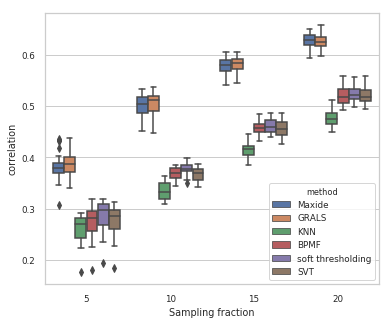

In [35]:
sns.set_style('whitegrid')
plt.figure(figsize=[6, 5])
sns.boxplot(x='fraction', y='correlation', hue='method', data=emap_total_flat)
plt.xlabel('Sampling fraction')
plt.savefig('./figures/prediction_performance_comparison_to_other_methods.pdf', bbox_inches='tight')

Now compute all the block-averaged predicted GI maps and look at performance

In [36]:
def threshold_emap(emap, clusters):
    mean_interactions = pd.DataFrame(index=pd.Index(sorted(clusters.unique())), columns=sorted(clusters.unique()))
    emap_correlation = emap.corr()
    emap_coherence = emap.copy()

    for pair in itertools.combinations_with_replacement(clusters.unique(), 2):
        genes_1 = clusters[clusters == pair[0]].index.tolist()
        genes_2 = clusters[clusters == pair[1]].index.tolist()
        mean_interactions.loc[pair[0], pair[1]] = emap.loc[genes_1][genes_2].mean().mean()
        mean_interactions.loc[pair[1], pair[0]] = emap.loc[genes_2][genes_1].mean().mean()
        
        avg_correlation_1 = emap_correlation.loc[genes_1][genes_2].mean().mean()
        avg_correlation_2 = emap_correlation.loc[genes_2][genes_1].mean().mean()
        for gene_1 in genes_1:
            for gene_2 in genes_2:
                emap_coherence.loc[gene_1][gene_2] = avg_correlation_1
                emap_coherence.loc[gene_2][gene_1] = avg_correlation_2
                    
    emap_thresholded = emap.copy()

    for pair in itertools.combinations_with_replacement(emap_thresholded.columns, 2):
        cluster1 = clusters.loc[pair[0]]
        cluster2 = clusters.loc[pair[1]]
        emap_thresholded.loc[pair[0], pair[1]] = mean_interactions.loc[cluster1, cluster2]
        emap_thresholded.loc[pair[1], pair[0]] = mean_interactions.loc[cluster2, cluster1]
    
    return emap_thresholded, emap_coherence, mean_interactions

Generate clusters used for block averaging

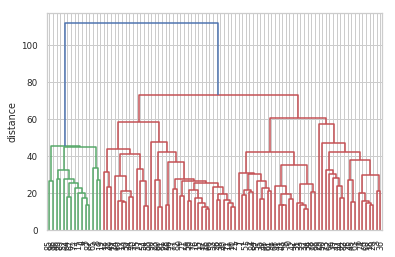

In [38]:
from scipy.cluster.hierarchy import fcluster, dendrogram, leaves_list

plt.ylabel('distance')
dendrogram(
    Z_emap,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [39]:
clusters = pd.Series(fcluster(Z_emap, 40, criterion='distance'),
                     emap_baseline.columns,
                     )

Baseline thresholded GI map to compare to

In [44]:
emap_baseline_thresh, emap_baseline_coherence, mean_interactions_baseline = threshold_emap(emap_baseline, clusters)

Now threshold all predicted GI maps for comparison

In [45]:
from tqdm import tqdm_notebook as progress
import itertools

In [46]:
thresholded_emaps = defaultdict(dict)
thresholded_corrs = defaultdict(dict)

for key, em in progress(emaps.iteritems(), total=len(emaps)):
    print(key)
    frac, it = key
    # the paper figures only look at the low sampling limit...higher sampling was for reviewers
    if frac <= 20:
        pred_types = ['pred_pmf', 'pred_soft', 'pred_svt', 'pred_grals', 'pred_knn', 'pred']
        for pred_type in pred_types:
            print('...{0}'.format(pred_type))
            em_thresh, _, _ = threshold_emap(em[pred_type], clusters)
            thresholded_emaps[key][pred_type] = em_thresh
            thresholded_corrs[key][pred_type] = upper_triangle(emap_baseline_thresh).corr(upper_triangle(em_thresh), method='spearman')  

HBox(children=(IntProgress(value=0, max=250), HTML(value=u'')))

(40, 3)
(80, 8)
(10, 17)
...pred_pmf



Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/tmn/.local/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(15, 20)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(40, 22)
(20, 20)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(15, 1)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(60, 13)
(20, 7)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(70, 12)
(50, 11)
(5, 8)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(80, 12)
(70, 19)
(10, 8)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(50, 22)
(40, 13)
(5, 5)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(10, 7)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(60, 8)
(40, 0)
(5, 18)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(10, 18)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(15, 11)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
..

...pred_knn
...pred
(60, 22)
(30, 4)
(60, 11)
(80, 2)
(70, 21)
(5, 9)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(50, 16)
(5, 15)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(80, 21)
(70, 24)
(10, 1)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(40, 6)
(80, 24)
(60, 6)
(15, 17)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(50, 5)
(20, 23)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(15, 2)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(60, 2)
(20, 2)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(80, 18)
(70, 3)
(50, 6)
(80, 15)
(70, 22)
(50, 21)
(60, 24)
(5, 2)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(5, 12)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred
(10, 2)
...pred_pmf
...pred_soft
...pred_svt
...pred_grals
...pred_knn
...pred


In [47]:
df = pd.DataFrame(thresholded_corrs).T
df_flat = df.reset_index().rename(columns={'level_0': 'fraction', 'level_1': 'it'}).melt(value_vars=df.columns, id_vars=['fraction', 'it']).rename(columns={'variable': 'method', 'value': 'correlation'})
df_flat['method'] = df_flat['method'].replace({'pred': 'Maxide',
                                  'pred_soft': 'soft thresholding',
                                  'pred_grals': 'GRALS',
                                  'pred_knn': 'KNN',
                                  'pred_svt': 'SVT',
                                  'pred_pmf': 'BPMF'})

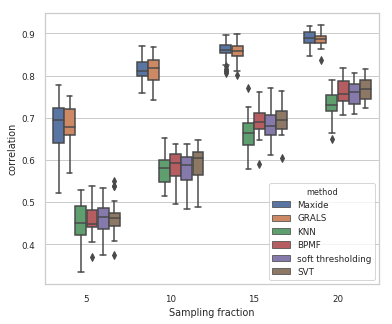

In [48]:
sns.set_style('whitegrid')
plt.figure(figsize=[6, 5])
sns.boxplot(x='fraction', y='correlation', hue='method', data=df_flat)
plt.xlabel('Sampling fraction')
plt.savefig('./figures/prediction_performance_comparison_to_other_methods_block_averaged.pdf', bbox_inches='tight')